Find the data here:
https://nemar.org/dataexplorer/detail?dataset_id=ds005420

In [1]:
import os
import re
import mne
import numpy as np
import matplotlib.pyplot as plt

from os.path import join
from tqdm.notebook import tqdm

In [2]:
def process_eeg(eeg_data, sample_rate):
    # eeg_data.set_eeg_reference(ref_channels='average', projection=False)
    eeg_data.resample(sample_rate, method='fft')
    return eeg_data

In [3]:
pattern = r'sub-\d+'
path_data = 'eeg_data'
data_array_oc = []
data_array_oa = []
sample_rate = 256
for folder_name in tqdm(os.listdir(path_data)):
    if re.match(pattern, folder_name):
        edf_path_oc = join(path_data, folder_name, "eeg", f"{folder_name}_task-oc_eeg.edf")
        edf_path_oa = edf_path_oc.replace('oc', 'oa')
        try:
            data = mne.io.read_raw_edf(edf_path_oc, preload=True)
            data_processed = process_eeg(data, sample_rate)
            data_array_oc.append(data_processed)
        except FileNotFoundError:
            print(f'OC data missing for {folder_name}')
        try:
            data = mne.io.read_raw_edf(edf_path_oa, preload=True)
            data_processed = process_eeg(data, sample_rate)
            data_array_oa.append(data_processed)
        except FileNotFoundError:
            print(f'OA data missing for {folder_name}')

  0%|          | 0/44 [00:00<?, ?it/s]

Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-1\eeg\sub-1_task-oc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 105499  =      0.000 ...   210.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-1\eeg\sub-1_task-oa_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 103999  =      0.000 ...   207.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-10\eeg\sub-10_task-oc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96499  =      0.000 ...   192.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-10

C:\Users\toell\AppData\Local\Temp\ipykernel_7900\883997146.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(edf_path_oa, preload=True)


Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-41\eeg\sub-41_task-oc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 163499  =      0.000 ...   326.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-41\eeg\sub-41_task-oa_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 79999  =      0.000 ...   159.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-42\eeg\sub-42_task-oc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 158999  =      0.000 ...   317.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\su

C:\Users\toell\AppData\Local\Temp\ipykernel_7900\883997146.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(edf_path_oa, preload=True)


Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-46\eeg\sub-46_task-oc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 176999  =      0.000 ...   353.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-46\eeg\sub-46_task-oa_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 152499  =      0.000 ...   304.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-47\eeg\sub-47_task-oc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 164999  =      0.000 ...   329.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\s

C:\Users\toell\AppData\Local\Temp\ipykernel_7900\883997146.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(edf_path_oc, preload=True)


Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-49\eeg\sub-49_task-oa_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 130999  =      0.000 ...   261.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-5\eeg\sub-5_task-oc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 94499  =      0.000 ...   188.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-5\eeg\sub-5_task-oa_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91999  =      0.000 ...   183.998 secs...
Extracting EDF parameters from C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\eeg_data\sub-50\

C:\Users\toell\AppData\Local\Temp\ipykernel_7900\883997146.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(edf_path_oa, preload=True)


OC filtered
Using matplotlib as 2D backend.


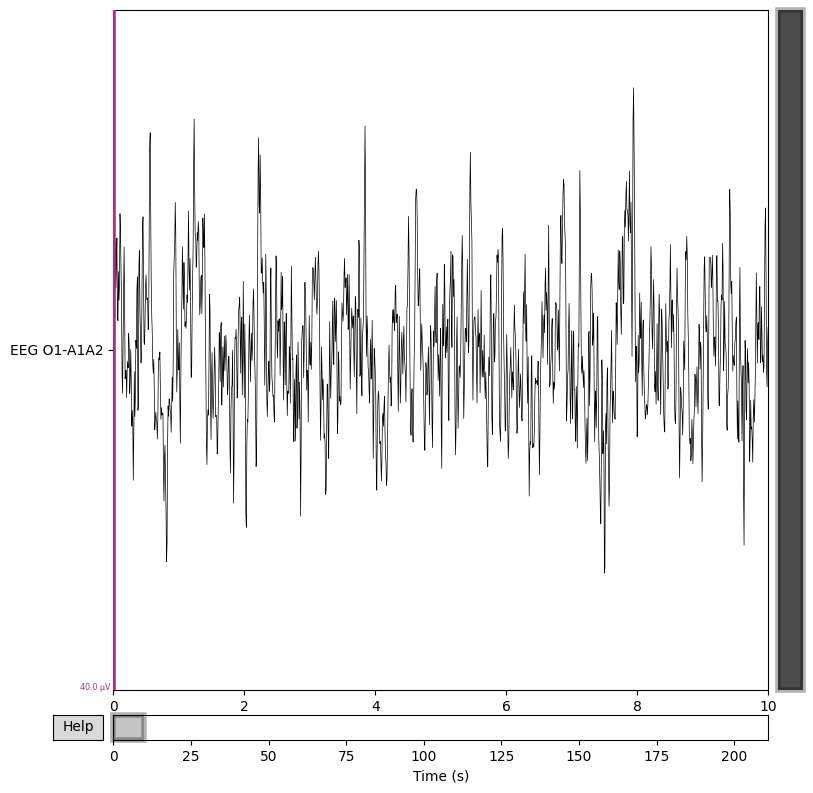

OA filtered


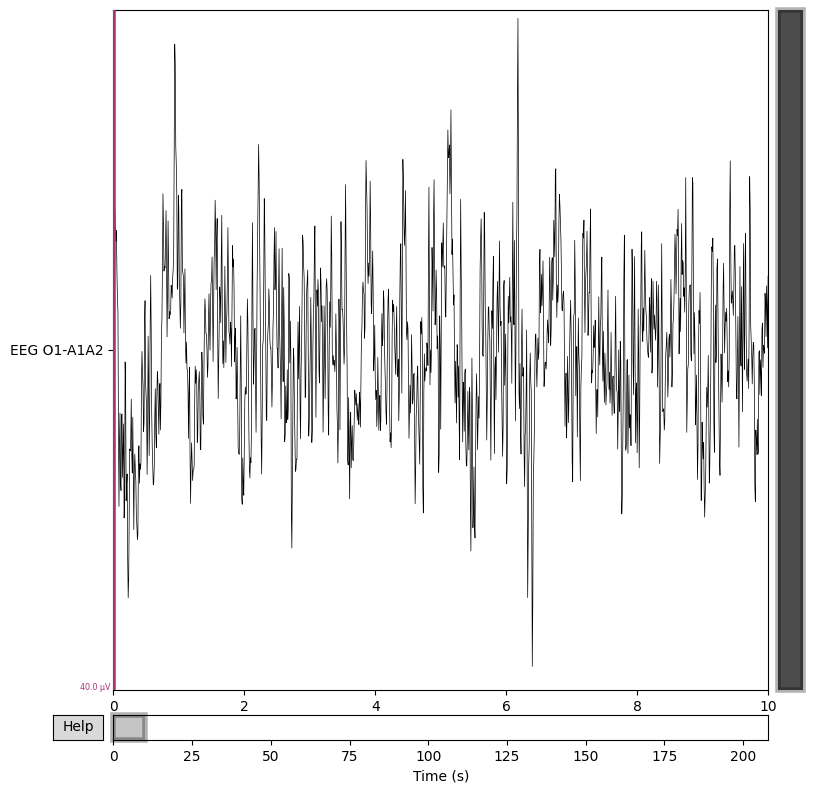

OC filtered


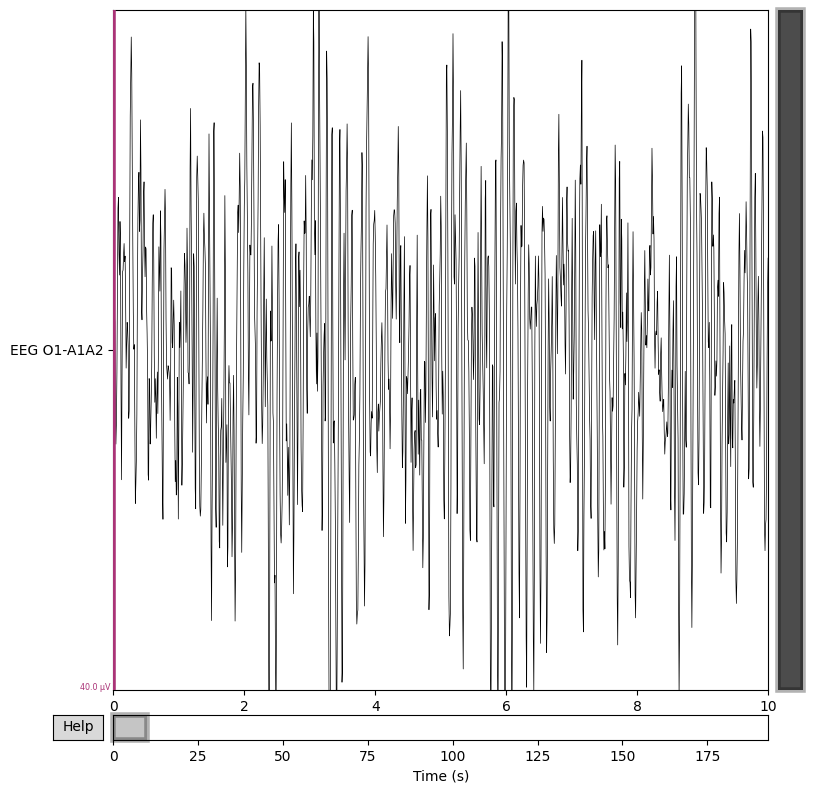

OA filtered


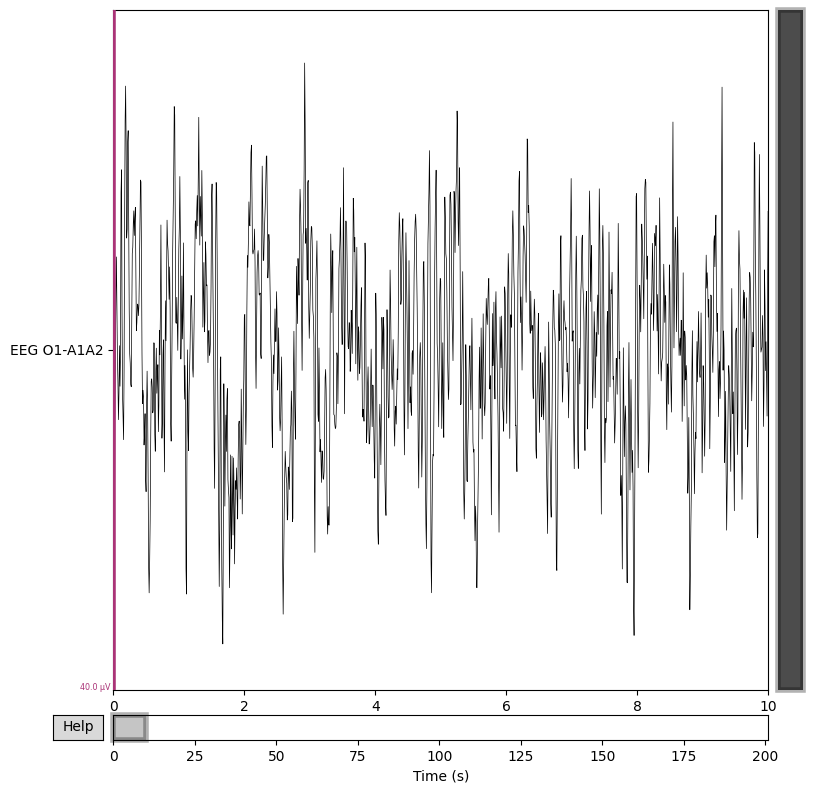

OC filtered


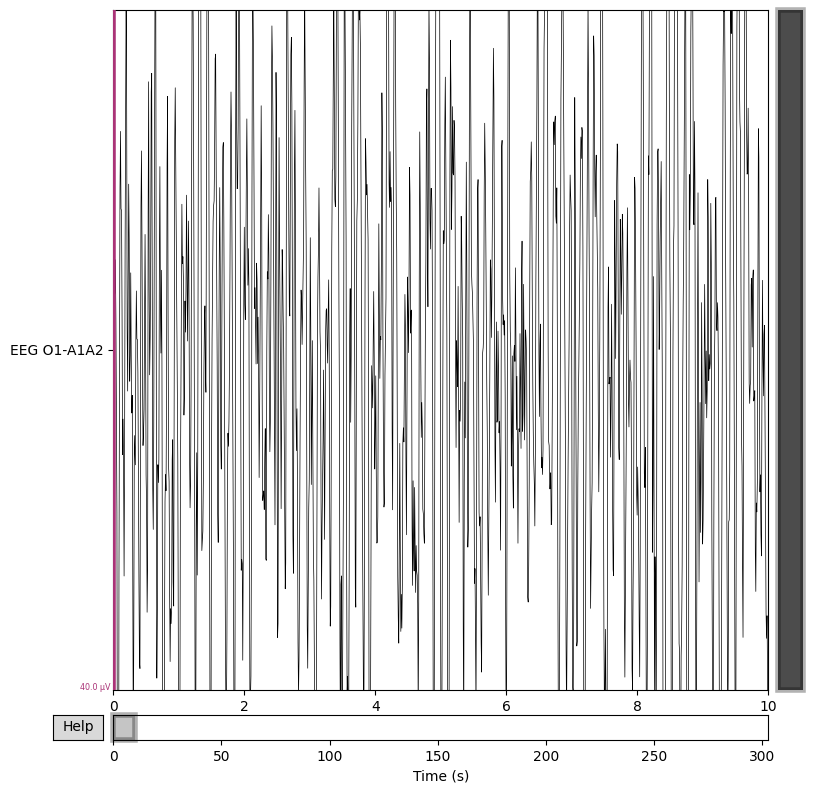

OA filtered


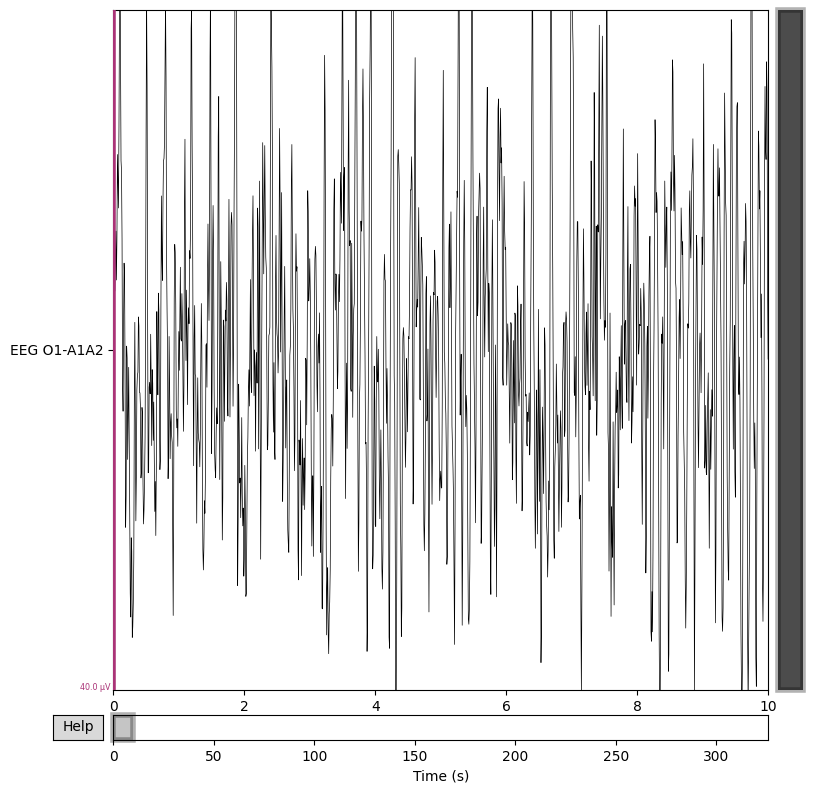

OC filtered


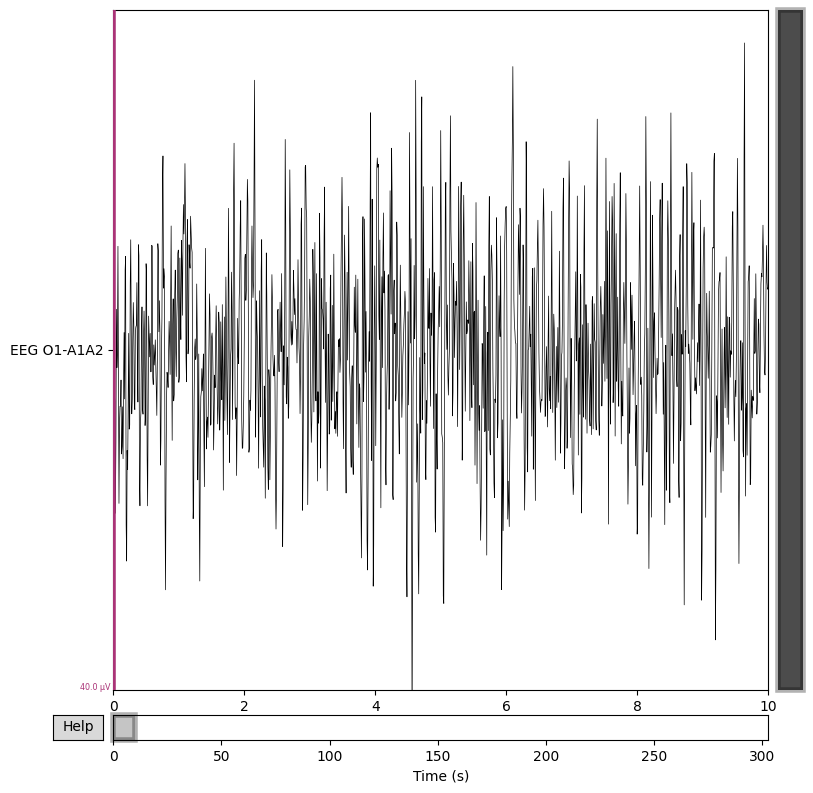

OA filtered


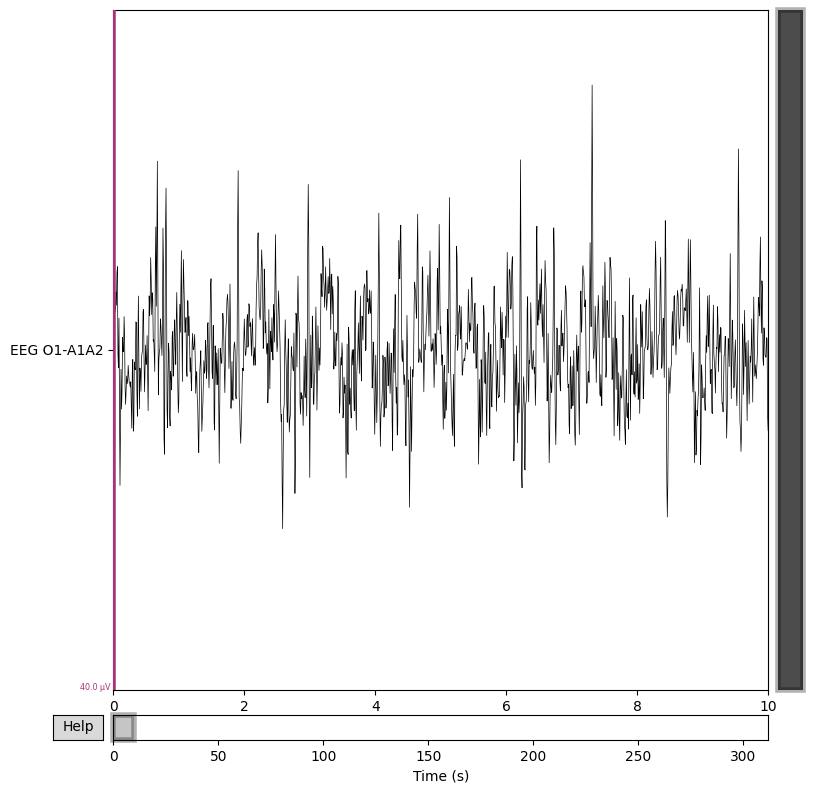

OC filtered


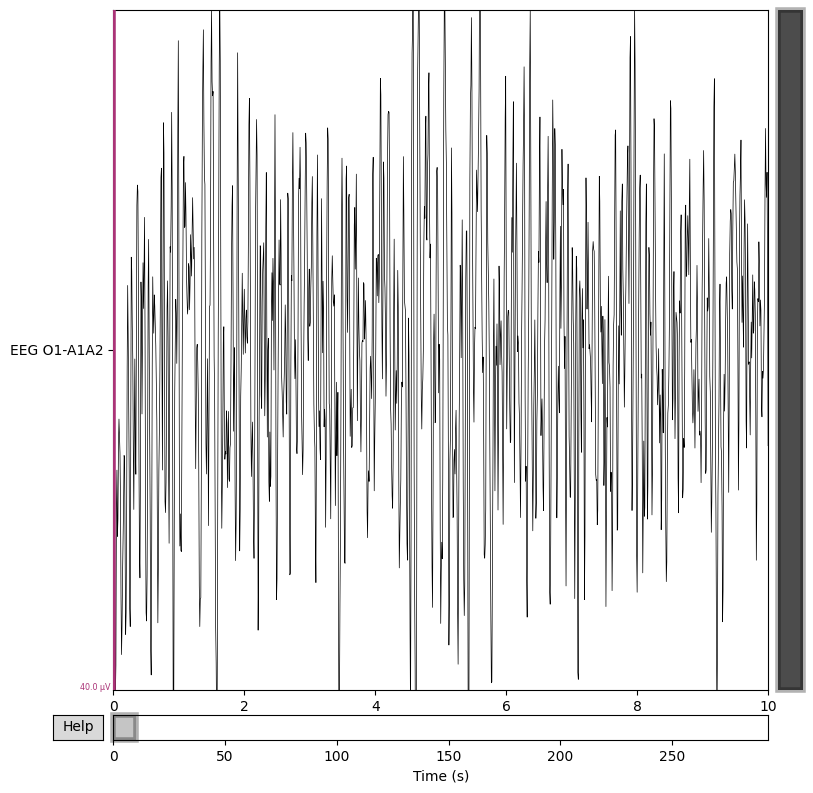

OA filtered


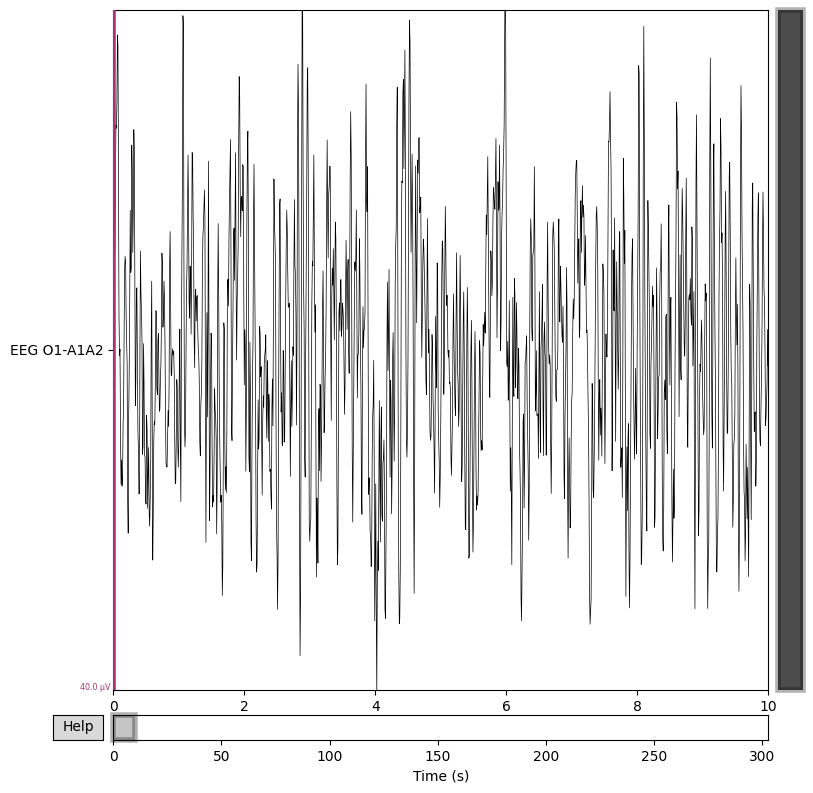

In [6]:
channel_slice = slice(17, 18)
subject_slice = slice(0, 5)
filter_min, filter_max = 1, 40
alphas_oc, alphas_oa = [], []
for arr_oc, arr_oa in zip(data_array_oc[subject_slice], data_array_oa[subject_slice]):
    data_filtered_oc = arr_oc.copy().filter(filter_min, filter_max, fir_design='firwin', phase='zero', verbose=False).pick(channel_slice)
    print(f'OC filtered')
    data_filtered_oc.plot(n_channels=20)

    data_filtered_oa = arr_oa.copy().filter(filter_min, filter_max, fir_design='firwin', phase='zero', verbose=False).pick(channel_slice)
    print(f'OA filtered')
    data_filtered_oa.plot(n_channels=20)
    
    alpha_oc = np.abs(data_filtered_oc.get_data()).mean()
    alpha_oa = np.abs(data_filtered_oa.get_data()).mean()
    alphas_oc.append(alpha_oc)
    alphas_oa.append(alpha_oa)
    
alphas_oc, alphas_oa = np.array(alphas_oc).flatten(), np.array(alphas_oa).flatten()

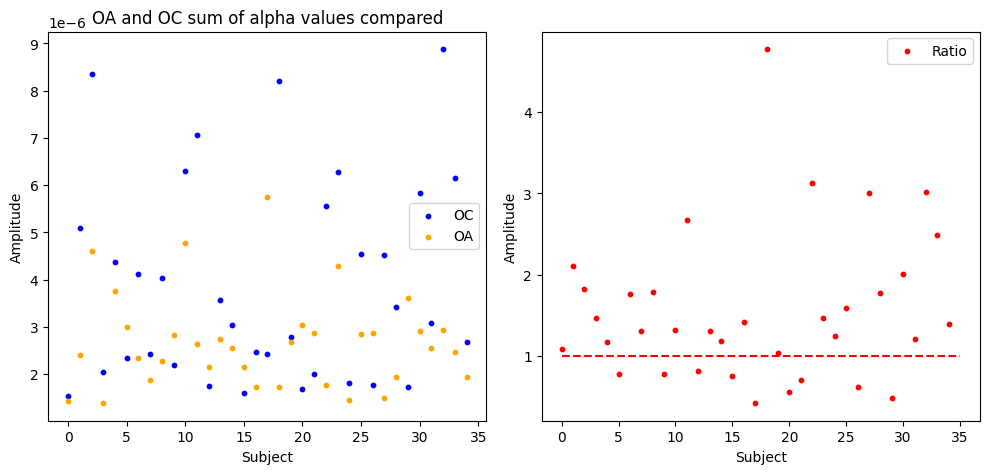

In [5]:
s = 10 
fig = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.subplot(1,2,1)
plt.scatter(range(len(alphas_oc)), alphas_oc, label='OC', color='blue', s=s) 
plt.scatter(range(len(alphas_oa)), alphas_oa, label='OA', color='orange', s=s)
plt.title('OA and OC sum of alpha values compared')
plt.xlabel('Subject')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(range(len(alphas_oc)), alphas_oc / alphas_oa, label='Ratio', color='red', s=s)
plt.hlines(1, 0, len(alphas_oc), linestyles='dashed', color='red')
plt.xlabel('Subject')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()